In [1]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import PIL
from PIL import Image
from google.colab import files, drive
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


import shutil

In [3]:
# Mount drive
#drive.mount('/content/drive')

In [ ]:
# Upload dataset
#uploaded = files.upload()

In [5]:
# Define the path in Drive
project_path = "/kaggle/input"
#"/content/drive/My Drive/Natural Disaster Damage Image Classification"
dataset_dir = os.path.join(project_path, "natural-disaster-damage")

# Make sure the directory exists
#os.makedirs(dataset_dir, exist_ok=True)

# Unzip into Google Drive

#with zipfile.ZipFile("Natural Disaster Damage Image Classification Dataset.zip", 'r') as zip_ref:
 #   zip_ref.extractall(dataset_dir)
print(f"Number of classes in my dataset: {len(os.listdir(dataset_dir))}")

Number of classes in my dataset: 1


In [6]:
os.listdir(dataset_dir)

['dataset']

In [8]:
# Detect and save device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using: {device}")

Using: cuda


In [9]:
# Get dataset
datasets_dir = os.path.join(dataset_dir, "dataset")
print(f"Number of classes in my dataset: {len(os.listdir(datasets_dir))}")

Number of classes in my dataset: 4


In [10]:
for sub_directory in os.listdir(datasets_dir):
    sub_directory_path = os.path.join(datasets_dir, sub_directory)

    # Get image files
    image_files = [
        f for f in os.listdir(sub_directory_path)
    ]

    print(f"{sub_directory} | Number of images: {len(image_files)}")

Flood Damage | Number of images: 193
Sinkhole | Number of images: 191
Earthquake | Number of images: 196
Forest Fire | Number of images: 177


In [11]:
tranform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [12]:
image_dataset = ImageFolder(root = datasets_dir, transform = tranform)
dataloader = DataLoader(image_dataset, batch_size = 32)
print(f"Total Number of images: {len(image_dataset)}")

Total Number of images: 757


In [13]:
# List all class folders
print(f"Classes in dataset: {image_dataset.classes}")
print(f"We have {len(image_dataset.classes)} classes in our dataset")
print()
print("Tensor shape for one image:")
print(image_dataset[0][0].shape)

Classes in dataset: ['Earthquake', 'Flood Damage', 'Forest Fire', 'Sinkhole']
We have 4 classes in our dataset

Tensor shape for one image:
torch.Size([3, 224, 224])


In [14]:
# Get one batch
first_batch = next(iter(dataloader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


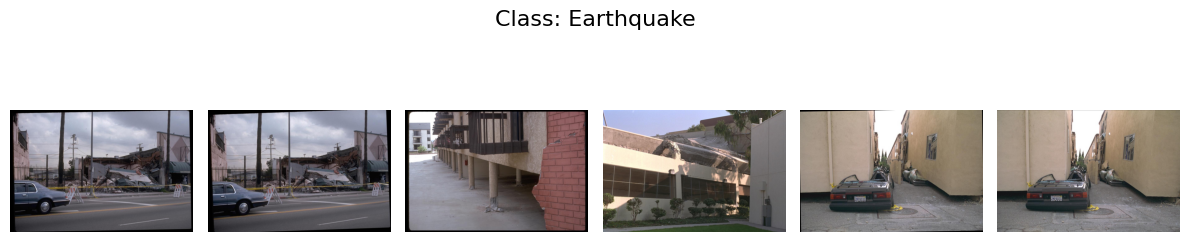

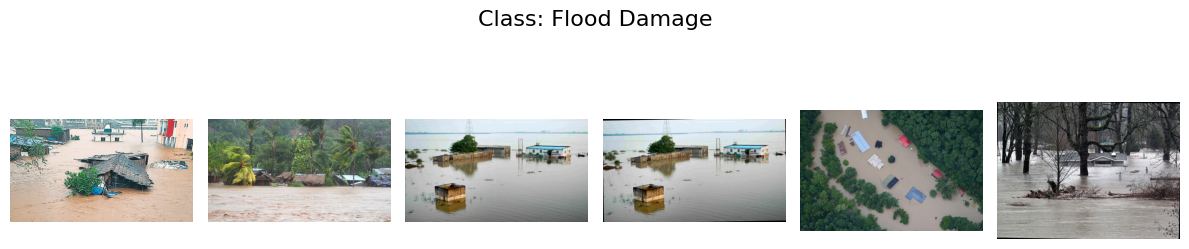

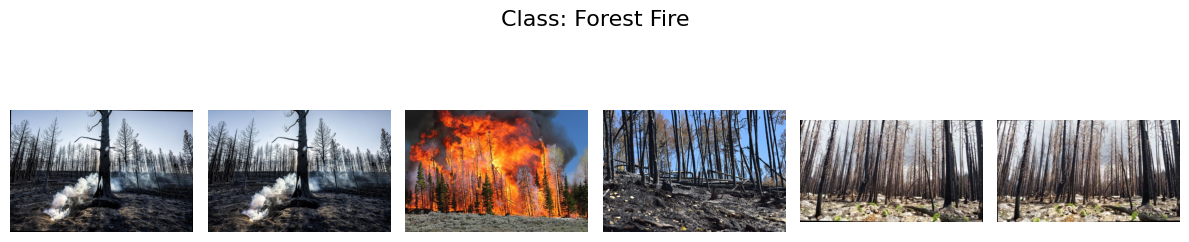

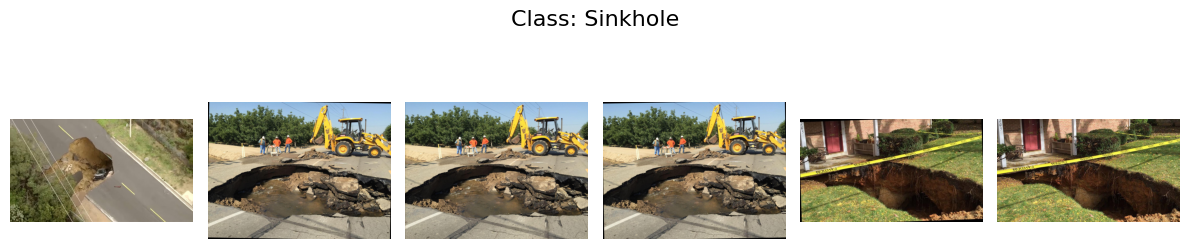

In [ ]:
# Display 6 images per class
for class_name in image_dataset.classes:
    class_path = os.path.join(datasets_dir, class_name)
    image_files = sorted(os.listdir(class_path))[:6]  # First 6 images

    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_path, image_file)
        img = Image.open(img_path)

        plt.subplot(1, 6, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
# Data Splitting
train_data, val_data = random_split(image_dataset, [0.8, 0.2])

length_train = len(train_data)
length_val = len(val_data)
length_data = len(image_dataset)
training_percent = np.round(100 * length_train / length_data, 2)
val_percent = np.round(100 * length_val / length_data, 2)

print(f"Train data is {training_percent}% of our data")
print(f"Validation data is {val_percent}% of our data")

Train data is 80.05% of our data
Validation data is 19.95% of our data


In [16]:
# Compute Mean & STD for each color channels
def get_mean_std(loader):

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


#mean, std = get_mean_std(dataloader)

mean = [0.4620, 0.4494, 0.4231]
std = [0.2367, 0.2327, 0.2446]

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: [0.462, 0.4494, 0.4231]
Standard deviation: [0.2367, 0.2327, 0.2446]


In [17]:
# Data Augmentation

# Define training augmentations
training_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define tranformation for validation and testing
val_tranformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std),
])

In [18]:
# Transform splits
train_data = datasets.ImageFolder(root = datasets_dir, transform = training_augmentation)
val_data = datasets.ImageFolder(root = datasets_dir, transform = val_tranformation)

In [19]:
# create DataLoader for splits

batch_size = 32

training_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False, num_workers=2)

single_batch = next(iter(training_loader))[0]
single_shape = single_batch.shape
print(f"Shape of one batch: {single_shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


In [20]:
# Load ResNet50 with pretrained ImageNet weights
res_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s] 


In [21]:
# Create the model summary
summary(res_model, input_size = single_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [22]:
# Move the model to device
res_model.to(device)

# Move our single_batch to device
single_batch_cuda = single_batch.to(device)

print("Single Test batch is running on:", single_batch_cuda.device)

Single Test batch is running on: cuda:0


In [23]:
# Test the model on single test batch
res_model_test = res_model(single_batch_cuda)
res_model_test_shape = res_model_test.shape

print("Output shape:", res_model_test_shape)

Output shape: torch.Size([32, 1000])


In [24]:
# Get the last layer
list(res_model.named_modules())[-1]

('fc', Linear(in_features=2048, out_features=1000, bias=True))

In [25]:
# Save number of input features to last layer
in_features = res_model.fc.in_features
in_features

2048

In [26]:
# get the number of classes in our dataset
num_classes = len(train_data.classes)
num_classes

4

In [27]:
# Build our new layer
new_classifier = torch.nn.Sequential()
linear_layer = torch.nn.Linear(in_features = in_features, out_features = 256)
output_layer = torch.nn.Linear(in_features = 256, out_features = num_classes)

# Add new layers to our new layer
new_classifier.append(linear_layer)
new_classifier.append(torch.nn.ReLU())
new_classifier.append(torch.nn.Dropout())
new_classifier.append(output_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
)

In [28]:
# Replace the last layer
res_model.fc = new_classifier

# Create the model summary
summary(res_model, input_size = single_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [29]:
# Cross validation
kfold_splitter = sklearn.model_selection.KFold(n_splits = 5, shuffle=True, random_state=42)

nums_train, nums_val = next(kfold_splitter.split(range(100)))
fraction_fold = len(nums_val) / (len(nums_train) + len(nums_val))
print(f"One fold is {100 * fraction_fold:.2f}% of our training set")

One fold is 20.00% of our training set


In [30]:
# Define LossFunction and Optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(res_model.parameters())

In [32]:
# Create a directory for saving models
out_put = "/kaggle/working/"
save_path = os.path.join(out_put, "resnet50")
os.makedirs(save_path, exist_ok=True)
model_checkpoint = os.path.join(save_path, 'resnet50_best.pth')
print(f"Models will be saved to: {save_path}")

Models will be saved to: /kaggle/working/resnet50


In [33]:
# Hyperparameters
num_epochs = 50
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0
save_path = '.'  # Change as needed

# Mixed precision training setup
scaler = torch.amp.GradScaler("cuda")

for epoch in range(num_epochs):
    res_model.train()
    running_loss = 0.0

    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = res_model(inputs)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(training_loader)

    # Validation
    res_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = res_model(inputs)
                loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early Stopping and Model Saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(res_model.state_dict(), os.path.join(save_path, "resnet50_best_weights.pth"))
        print(f"→ Best model saved at Epoch {epoch+1} with val_loss = {val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"→ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print(f"Early stopping at Epoch {epoch+1}")
            break

print("Training complete.")

Epoch 1/50 | Train Loss: 0.6413 | Val Loss: 0.5600 | Val Acc: 88.11%
→ Best model saved at Epoch 1 with val_loss = 0.5600
Epoch 2/50 | Train Loss: 0.2902 | Val Loss: 2.5020 | Val Acc: 66.18%
→ No improvement. Early stop counter: 1/10
Epoch 3/50 | Train Loss: 0.4063 | Val Loss: 0.3720 | Val Acc: 86.92%
→ Best model saved at Epoch 3 with val_loss = 0.3720
Epoch 4/50 | Train Loss: 0.2152 | Val Loss: 0.5782 | Val Acc: 85.34%
→ No improvement. Early stop counter: 1/10
Epoch 5/50 | Train Loss: 0.2136 | Val Loss: 0.1546 | Val Acc: 94.85%
→ Best model saved at Epoch 5 with val_loss = 0.1546
Epoch 6/50 | Train Loss: 0.1817 | Val Loss: 0.7404 | Val Acc: 80.05%
→ No improvement. Early stop counter: 1/10
Epoch 7/50 | Train Loss: 0.1256 | Val Loss: 0.0364 | Val Acc: 98.81%
→ Best model saved at Epoch 7 with val_loss = 0.0364
Epoch 8/50 | Train Loss: 0.0840 | Val Loss: 0.0498 | Val Acc: 98.15%
→ No improvement. Early stop counter: 1/10
Epoch 9/50 | Train Loss: 0.1325 | Val Loss: 0.7813 | Val Acc: 89

In [34]:
# Send model to device
model = res_model.to(device)

# Initialize lists for predictions and labels
all_preds = []
all_labels = []

# Loop through the test/validation loader
with torch.no_grad():
    for images, labels in valid_loader:  # Replace with your DataLoader
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [35]:
# Get the class names
class_names = image_dataset.classes

# Calculate Metrics
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, target_names=class_names)  # Replace class_names list with your class labels

# Print Metrics
print("Evaluation Metrics")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", report)

Evaluation Metrics
Accuracy:  0.9974
Precision: 0.9974
Recall:    0.9972
F1 Score:  0.9973

Classification Report:
               precision    recall  f1-score   support

  Earthquake       1.00      1.00      1.00       196
Flood Damage       0.99      1.00      1.00       193
 Forest Fire       1.00      0.99      0.99       177
    Sinkhole       0.99      1.00      1.00       191

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



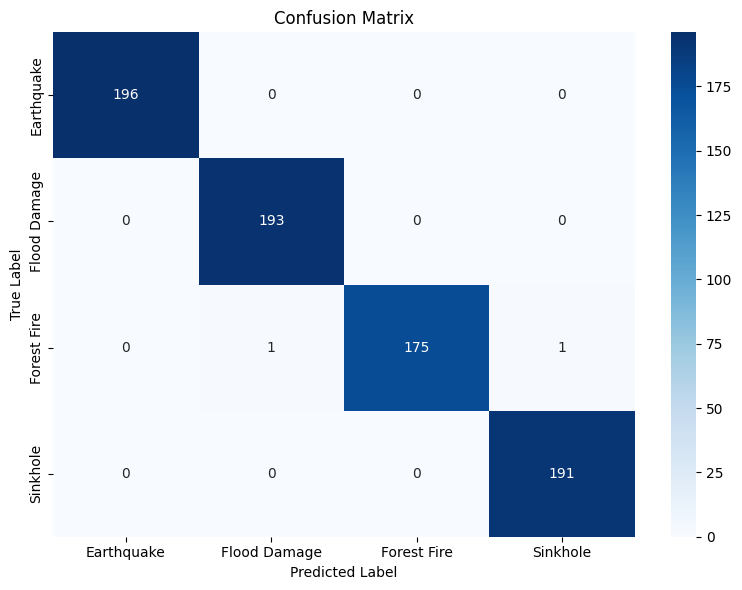

In [36]:
# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()